In [1]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
! kaggle datasets list

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


In [4]:
! kaggle datasets download -d anikannal/solar-power-generation-data

Dataset URL: https://www.kaggle.com/datasets/anikannal/solar-power-generation-data
License(s): copyright-authors
  0% 0.00/1.90M [00:00<?, ?B/s]
100% 1.90M/1.90M [00:00<00:00, 44.8MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('solar-power-generation-data.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import matplotlib.dates as mdates
import os

In [7]:
gen_1 = pd.read_csv('/content/Plant_1_Generation_Data.csv')
sens_1 = pd.read_csv('/content/Plant_1_Weather_Sensor_Data.csv')
gen_2 = pd.read_csv('/content/Plant_2_Generation_Data.csv')
sens_2 = pd.read_csv('/content/Plant_2_Weather_Sensor_Data.csv')

# 1. EDA & Condition Monitoring

In [8]:
gen_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   PLANT_ID     68778 non-null  int64  
 2   SOURCE_KEY   68778 non-null  object 
 3   DC_POWER     68778 non-null  float64
 4   AC_POWER     68778 non-null  float64
 5   DAILY_YIELD  68778 non-null  float64
 6   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.7+ MB


Let's look at the column descriptions:

- DATE_TIME: Date and time for each observation. Observations recorded at 15 minute intervals.
- PLANT_ID: this will be common for the entire file
- SOURCE_KEY: Source key in this file stands for the inverter id.
- DC_POWER: Amount of DC power generated by the inverter (source_key) in this 15 minute interval. Units - kW.
- AC_POWER: Amount of AC power generated by the inverter (source_key) in this15 minute interval. Units - kW.
- TOTAL_YIELD: This is the total yield for the inverter till that point in time.

In [9]:
sens_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            3182 non-null   object 
 1   PLANT_ID             3182 non-null   int64  
 2   SOURCE_KEY           3182 non-null   object 
 3   AMBIENT_TEMPERATURE  3182 non-null   float64
 4   MODULE_TEMPERATURE   3182 non-null   float64
 5   IRRADIATION          3182 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 149.3+ KB


DATE_TIME and PLANT_ID are identical with the description above. Other than that:

- SOURCE_KEY: Stands for the sensor panel id. This will be common for the entire file because there's only one sensor panel for the plant.
- AMBIENT_TEMPERATURE: This is the ambient temperature at the plant. Note: After comparing this data with weather data in Gandikotta (Andhra), I assume the correct unit for this data is  °C

- MODULE_TEMPERATURE: There's a module (solar panel) attached to the sensor panel. This is the temperature reading for that module. Note: After comparing this data with other publications, I assume the correct unit for this data is  °C

- IRRADATION: Amount of irradiation for the 15 minute interval. Note: After comparing this data with other publications, I assume the correct unit for this data is  kW/m2

In [10]:
gen_1.describe()

PLANT_ID      DC_POWER      AC_POWER   DAILY_YIELD   TOTAL_YIELD
count    68778.0  68778.000000  68778.000000  68778.000000  6.877800e+04
mean   4135001.0   3147.426211    307.802752   3295.968737  6.978712e+06
std          0.0   4036.457169    394.396439   3145.178309  4.162720e+05
min    4135001.0      0.000000      0.000000      0.000000  6.183645e+06
25%    4135001.0      0.000000      0.000000      0.000000  6.512003e+06
50%    4135001.0    429.000000     41.493750   2658.714286  7.146685e+06
75%    4135001.0   6366.964286    623.618750   6274.000000  7.268706e+06
max    4135001.0  14471.125000   1410.950000   9163.000000  7.846821e+06

In [11]:
sens_1.describe()

PLANT_ID  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION
count     3182.0          3182.000000         3182.000000  3182.000000
mean   4135001.0            25.531606           31.091015     0.228313
std          0.0             3.354856           12.261222     0.300836
min    4135001.0            20.398505           18.140415     0.000000
25%    4135001.0            22.705182           21.090553     0.000000
50%    4135001.0            24.613814           24.618060     0.024653
75%    4135001.0            27.920532           41.307840     0.449588
max    4135001.0            35.252486           65.545714     1.221652

In [12]:
gen_1.isna().sum()

DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64

In [13]:
sens_1.isna().sum()

DATE_TIME              0
PLANT_ID               0
SOURCE_KEY             0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64

Seems like we have no missing values. We can use the PLANT_ID column to check if our data only contains information of one power plant:

In [14]:
gen_1['PLANT_ID'].nunique()

1

In [15]:
sens_1['PLANT_ID'].nunique()

1

We only have data from one plant, as expected. Let's find out how many inverters are in the database and how many measurements there are for each inverter?

In [16]:
gen_1['SOURCE_KEY'].value_counts()

SOURCE_KEY
bvBOhCH3iADSZry    3155
1BY6WEcLGh8j5v7    3154
7JYdWkrLSPkdwr4    3133
VHMLBKoKgIrUVDU    3133
ZnxXDlPa8U1GXgE    3130
ih0vzX44oOqAx2f    3130
z9Y9gH1T5YWrNuG    3126
wCURE6d3bPkepu2    3126
uHbuxQJl8lW7ozc    3125
pkci93gMrogZuBj    3125
iCRJl6heRkivqQ3    3125
rGa61gmuvPhdLxV    3124
sjndEbLyjtCKgGv    3124
McdE0feGgRqW7Ca    3124
zVJPv84UY57bAof    3124
ZoEaEvLYb1n2sOq    3123
1IF53ai7Xc0U56Y    3119
adLQvlD726eNBSB    3119
zBIq5rxdHJRwDNY    3119
WRmjgnKYAwPKWDb    3118
3PZuoBAID5Wc2HD    3118
YxYtjZvoooNbGkE    3104
Name: count, dtype: int64

In [17]:
print('There are {} different inverters. Number of measurements per inverter range from {} to {}.' .format(gen_1.SOURCE_KEY.nunique(),gen_1.SOURCE_KEY.value_counts().min(), gen_1.SOURCE_KEY.value_counts().max() ))

There are 22 different inverters. Number of measurements per inverter range from 3104 to 3155.


There are 22 unique inverters in the dataset, each with between 3104 and 3155 measurements. This inconsistency might affect the performance of prediction models and should be considered. Because each entry represents a 15-minute measurement, the maximum difference of 51 entries equates to a time difference of nearly 13 hours.

### 1.1  **Preprocess and Merge Datsets**

In [18]:
df_gen1 = gen_1.copy()
df_sens1 = sens_1.copy()
df_gen2 = gen_2.copy()
df_sens2 = sens_2.copy()

We intend to combine the two datasets. To achieve this, we will standardize the DATE_TIME formats, eliminate redundant columns, and merge the datasets based on the DATE_TIME column. Additionally, we will extract separate date and time columns and assign numerical labels from 1 to 22 to the inverters.

In [19]:
# adjust the dateme format
df_gen1['DATE_TIME'] = pd.to_datetime(df_gen1['DATE_TIME'],format = '%d-%m-%Y %H:%M')
df_sens1['DATE_TIME'] = pd.to_datetime(df_sens1['DATE_TIME'],format = '%Y-%m-%d %H:%M:%S')
df_gen2['DATE_TIME'] = pd.to_datetime(df_gen2['DATE_TIME'],format = '%Y-%m-%d %H:%M:%S') # Changed the format to match the actual format of the date and time strings.
df_sens2['DATE_TIME'] = pd.to_datetime(df_sens2['DATE_TIME'],format = '%Y-%m-%d %H:%M:%S')

# Dropping the unnecessary columns and merge both the dataframes along DATE_TIME
df_plant1 = pd.merge(df_gen1.drop(columns = ['PLANT_ID']), df_sens1.drop(columns = ['PLANT_ID', 'SOURCE_KEY']), on='DATE_TIME')

In [20]:
df_plant1.head()

DATE_TIME       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0 2020-05-15  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6259559.0   
1 2020-05-15  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6183645.0   
2 2020-05-15  3PZuoBAID5Wc2HD       0.0       0.0          0.0    6987759.0   
3 2020-05-15  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7602960.0   
4 2020-05-15  McdE0feGgRqW7Ca       0.0       0.0          0.0    7158964.0   

   AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  
0            25.184316           22.857507          0.0  
1            25.184316           22.857507          0.0  
2            25.184316           22.857507          0.0  
3            25.184316           22.857507          0.0  
4            25.184316           22.857507          0.0

In [21]:
# Adding inverter number column to the dataframe
sensor_keys = df_plant1['SOURCE_KEY'].unique()
sensor_numbers = dict(zip(sensor_keys, range(1, len(sensor_keys) + 1)))

# Add SENSOR_NUM column using map
df_plant1['SENSOR_NUM'] = df_plant1['SOURCE_KEY'].map(sensor_numbers)

# Add SENSOR_NAME column
df_plant1['SENSOR_NAME'] = df_plant1['SENSOR_NUM'].astype(str)

In [22]:
# Convert DATE_TIME to datetime if it's not already
df_plant1['DATE_TIME'] = pd.to_datetime(df_plant1['DATE_TIME'])

# Adding separate date and time columns
df_plant1['DATE'] = df_plant1['DATE_TIME'].dt.date
df_plant1['TIME'] = df_plant1['DATE_TIME'].dt.time

# Add hours and minutes for ML models
df_plant1['HOURS'] = df_plant1['DATE_TIME'].dt.hour
df_plant1['MINUTES'] = df_plant1['DATE_TIME'].dt.minute
df_plant1['MINUTES_PASS'] = df_plant1['HOURS'] * 60 + df_plant1['MINUTES']

# Add date as string column
df_plant1['DATE_STR'] = df_plant1['DATE'].astype(str)

In [23]:
df_plant1.head()

DATE_TIME       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0 2020-05-15  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6259559.0   
1 2020-05-15  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6183645.0   
2 2020-05-15  3PZuoBAID5Wc2HD       0.0       0.0          0.0    6987759.0   
3 2020-05-15  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7602960.0   
4 2020-05-15  McdE0feGgRqW7Ca       0.0       0.0          0.0    7158964.0   

   AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  SENSOR_NUM  \
0            25.184316           22.857507          0.0           1   
1            25.184316           22.857507          0.0           2   
2            25.184316           22.857507          0.0           3   
3            25.184316           22.857507          0.0           4   
4            25.184316           22.857507          0.0           5   

  SENSOR_NAME        DATE      TIME  HOURS  MINUTES  MINUTES_PASS    DATE_STR  
0           1  2020-05-15  00:00:00      0        0             0  2020-05-15  
1           2  2020-05-15  00:00:00      0        0             0  2020-05-15  
2           3  2020-05-15  00:00:00      0        0             0  2020-05-15  
3           4  2020-05-15  00:00:00      0        0             0  2020-05-15  
4           5  2020-05-15  00:00:00      0        0             0  2020-05-15

## 1.2 **Data Exploration & Failure Detection**

### 1.2.1 **Data Distribtion and Correlatios**

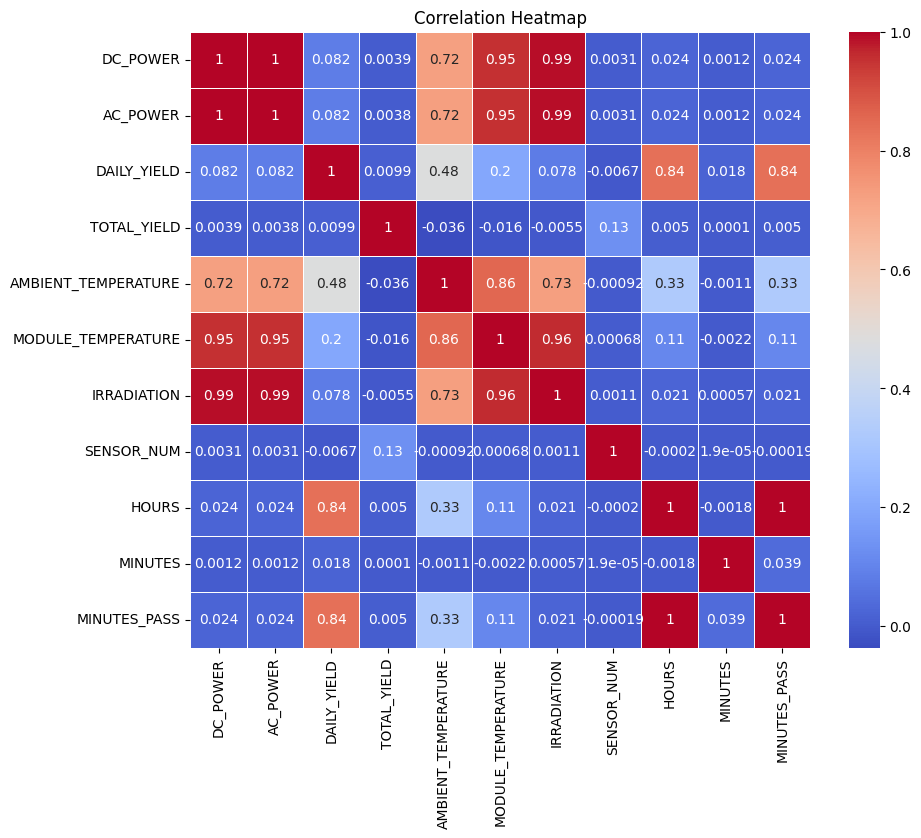

In [24]:
numeric_columns = df_plant1.select_dtypes(include=np.number).columns.tolist()
corr_df = df_plant1[numeric_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [25]:
#sns.pairplot(df_plant1[numeric_columns])
#plt.show()


# Solar Plant Performance Analysis: Key Insights and Anomalies

## Correlation Patterns

Our analysis reveals several significant correlations in the solar plant data:

1. **DC Power and AC Power**:
   - Strong positive correlation observed
   - Indicates efficient power conversion in the inverters
   - *Further investigation*: Quantify this correlation using Pearson's correlation coefficient

2. **Power and Irradiation**:
   - High correlation between power output and solar irradiation
   - Demonstrates the direct impact of sunlight on energy production
   - *Further investigation*: Plot a scatter diagram to visualize this relationship

3. **Power and Temperature**:
   - Correlation noted between power output and both module and ambient temperatures
   - Suggests temperature influence on solar panel efficiency
   - *Further investigation*: Analyze the temperature coefficient of power for the panels

4. **Daily Yield and Ambient Temperature**:
   - Correlation observed, likely due to increased daylight hours in warmer periods
   - *Further investigation*: Conduct a seasonal analysis to confirm this pattern

## Outlier Detection and Implications

Outliers identified in the data provide valuable insights for maintenance and fault detection:

1. **AC/DC Power vs. Irradiation Outliers**:
   - Indicates potential panel line failures
   - *Implication*: Sunlight present but no power generation suggests faulty photovoltaic cells
   - *Action item*: Implement automated alerts for significant power-irradiation mismatches

2. **DC Power vs. AC Power Outliers**:
   - Rare occurrences point to possible inverter issues
   - *Implication*: DC power input without expected AC power output suggests inverter malfunction
   - *Action item*: Develop a monitoring system to flag inverters with abnormal DC-AC conversion rates

## Equipment Groups and Installation Patterns

Analysis of TOTAL_YIELD vs. SENSOR_NUM reveals:

- Two distinct groups of inverters identified
- One group shows higher initial total yield
- *Hypothesis*: The higher-yield group was likely installed earlier
- *Action item*: Verify installation dates and analyze performance differences between groups

## Data Quality Concerns

A critical issue has been identified in the DAILY_YIELD data:

- **Observation**: DAILY_YIELD decreases during some days
- **Expected Behavior**: DAILY_YIELD should monotonically increase within a day
- **Root Cause**: DAILY_YIELD is calculated from measured DC_POWER
- **Implication**: Potential issues in data generation or collection process
- **Action Items**:
  1. Audit the data collection and processing pipeline
  2. Implement data validation checks to flag impossible DAILY_YIELD decreases
  3. Investigate the possibility of energy storage or grid feedback affecting measurements

## Recommendations for Further Analysis

1. **Time Series Decomposition**:
   - Analyze trends, seasonality, and residuals in power output data
   - Identify long-term performance degradation and cyclical patterns

2. **Predictive Maintenance Model**:
   - Develop a machine learning model to predict equipment failures based on identified outliers and patterns

3. **Efficiency Analysis**:
   - Calculate and track conversion efficiency (AC Power / DC Power) over time
   - Identify factors contributing to efficiency fluctuations

4. **Environmental Impact Study**:
   - Correlate power output with local weather data (beyond temperature and irradiation)
   - Assess the impact of factors like humidity, dust, and wind on plant performance

5. **Comparative Performance Analysis**:
   - If data is available, compare this plant's performance with industry benchmarks or similar plants in the region

By addressing these points and implementing the suggested analyses, we can gain a more comprehensive understanding of the solar plant's performance, improve maintenance strategies, and optimize energy production.

#### Daily Yield and AC Power

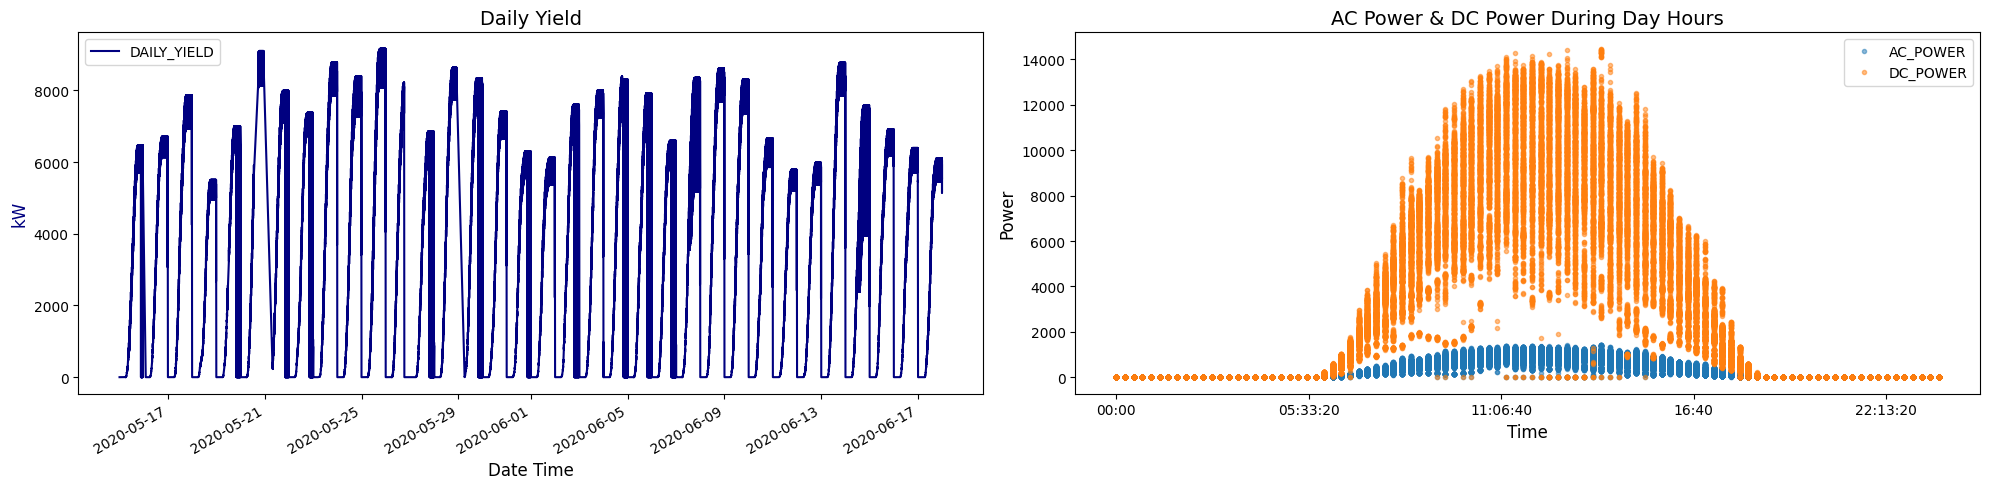

In [26]:
def plot_daily_yield_and_power(df_plant1):
    fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20, 5), dpi=100)

    # Daily yield plot
    df_plant1.plot(x='DATE_TIME', y='DAILY_YIELD', color='navy', ax=ax1)
    ax1.set_title('Daily Yield', fontsize=14)
    ax1.set_ylabel('kW', color='navy', fontsize=12)
    ax1.set_xlabel('Date Time', fontsize=12)
    ax1.tick_params(axis='both', which='major', labelsize=10)

    # AC & DC power plot
    power_data = df_plant1.set_index('TIME')[['AC_POWER', 'DC_POWER']]
    power_data.plot(style='.', ax=ax2, alpha=0.5)
    ax2.set_title('AC Power & DC Power During Day Hours', fontsize=14)
    ax2.set_ylabel('Power', fontsize=12)
    ax2.set_xlabel('Time', fontsize=12)
    ax2.tick_params(axis='both', which='major', labelsize=10)
    ax2.legend(fontsize=10)

    plt.tight_layout()
    plt.show()

plot_daily_yield_and_power(df_plant1)

#### Daily and Total Yield

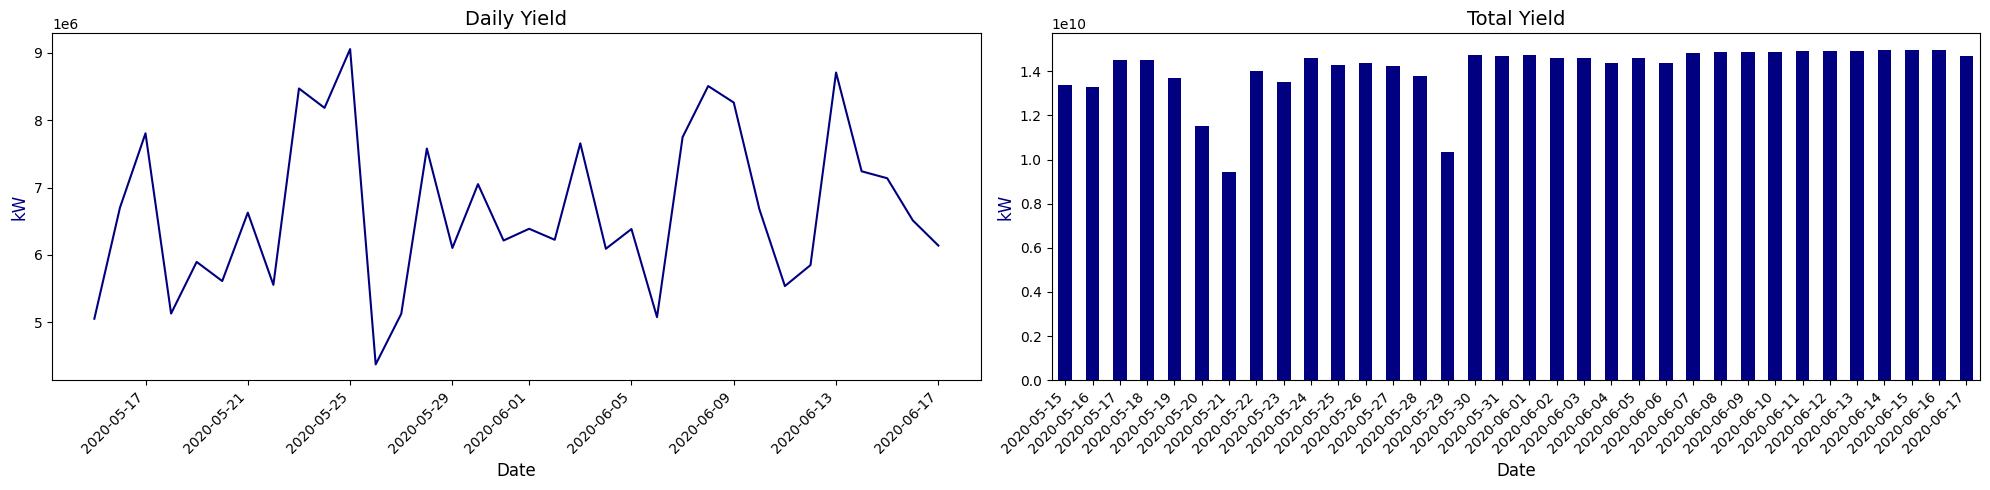

In [27]:
def plot_daily_yield_and_total_yield(df_plant1):
    # Ensure DATE_TIME is a datetime object
    df_plant1['date'] = pd.to_datetime(df_plant1['DATE_TIME']).dt.date

    # Group by date and sum, exclude 'DATE_TIME' column from sum
    df_plant1_grouped = df_plant1.groupby('date').sum(numeric_only=True)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5), dpi=100)

    # Plot Daily Yield
    df_plant1_grouped['DAILY_YIELD'].plot(ax=ax1, color='navy')
    ax1.set_title('Daily Yield', fontsize=14)
    ax1.set_ylabel('kW', color='navy', fontsize=12)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.tick_params(axis='both', which='major', labelsize=10)

    # Plot Total Yield
    df_plant1_grouped['TOTAL_YIELD'].plot(kind='bar', ax=ax2, color='navy')
    ax2.set_title('Total Yield', fontsize=14)
    ax2.set_ylabel('kW', color='navy', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.tick_params(axis='both', which='major', labelsize=10)

    # Auto-format x-axis labels
    fig.autofmt_xdate(rotation=45)

    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_daily_yield_and_total_yield(df_plant1)

#### Irradiation, Ambient and Module Temperature

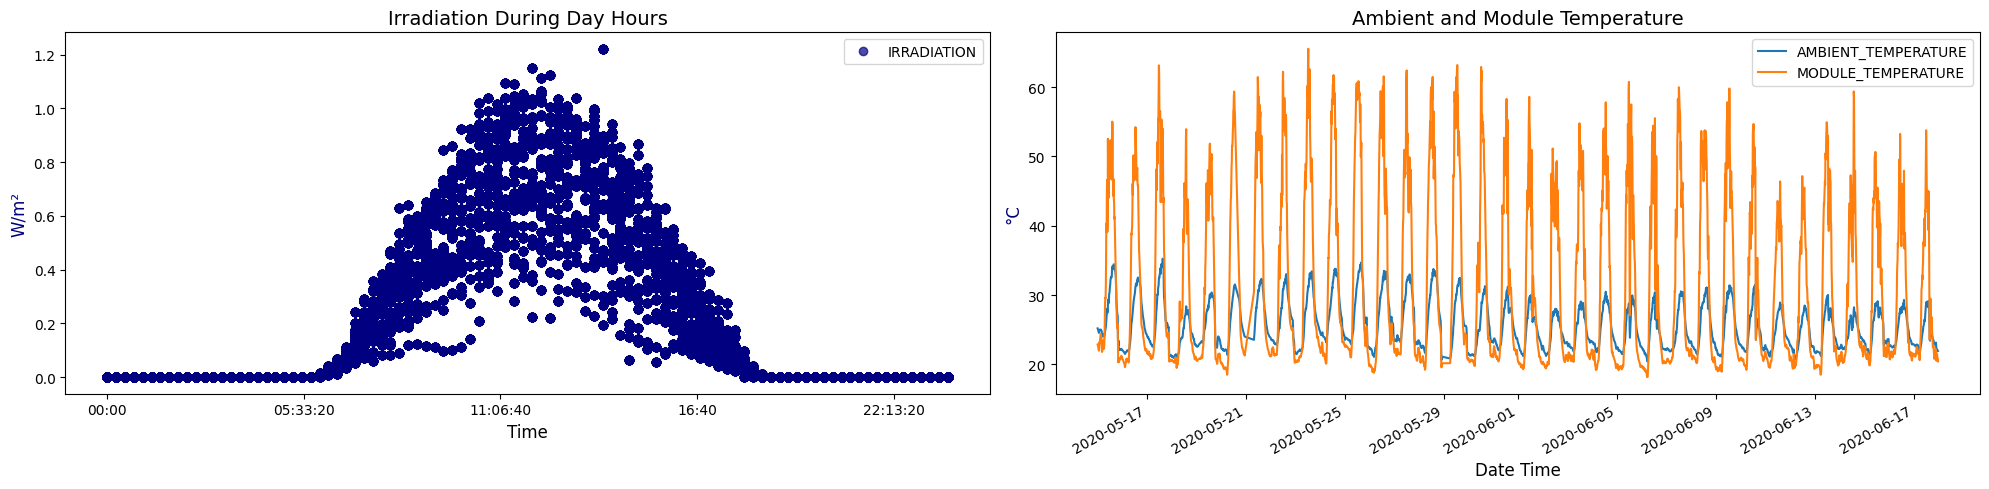

In [28]:
def plot_irradiation_and_temperature(df_plant1):
    fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20, 5), dpi=100)

    # Daily irradiation plot
    df_plant1.plot(x='TIME', y='IRRADIATION', ax=ax1, style='o', color='navy', alpha=0.7)
    ax1.set_title('Irradiation During Day Hours', fontsize=14)
    ax1.set_ylabel('W/m²', color='navy', fontsize=12)
    ax1.set_xlabel('Time', fontsize=12)
    ax1.tick_params(axis='both', which='major', labelsize=10)

    # Temperature plot
    df_plant1.set_index('DATE_TIME')[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE']].plot(ax=ax2)
    ax2.set_title('Ambient and Module Temperature', fontsize=14)
    ax2.set_ylabel('°C', color='navy', fontsize=12)
    ax2.set_xlabel('Date Time', fontsize=12)
    ax2.tick_params(axis='both', which='major', labelsize=10)
    ax2.legend(fontsize=10)

    plt.tight_layout()
    plt.show()

plot_irradiation_and_temperature(df_plant1)

### Temperature Profile

In [29]:
df_plant1['AMBIENT_TEMPERATURE'].describe()

count    68774.000000
mean        25.558521
std          3.361300
min         20.398505
25%         22.724491
50%         24.670178
75%         27.960429
max         35.252486
Name: AMBIENT_TEMPERATURE, dtype: float64

In [30]:
df_plant1['MODULE_TEMPERATURE'].describe()

count    68774.000000
mean        31.244997
std         12.308283
min         18.140415
25%         21.123944
50%         24.818984
75%         41.693659
max         65.545714
Name: MODULE_TEMPERATURE, dtype: float64

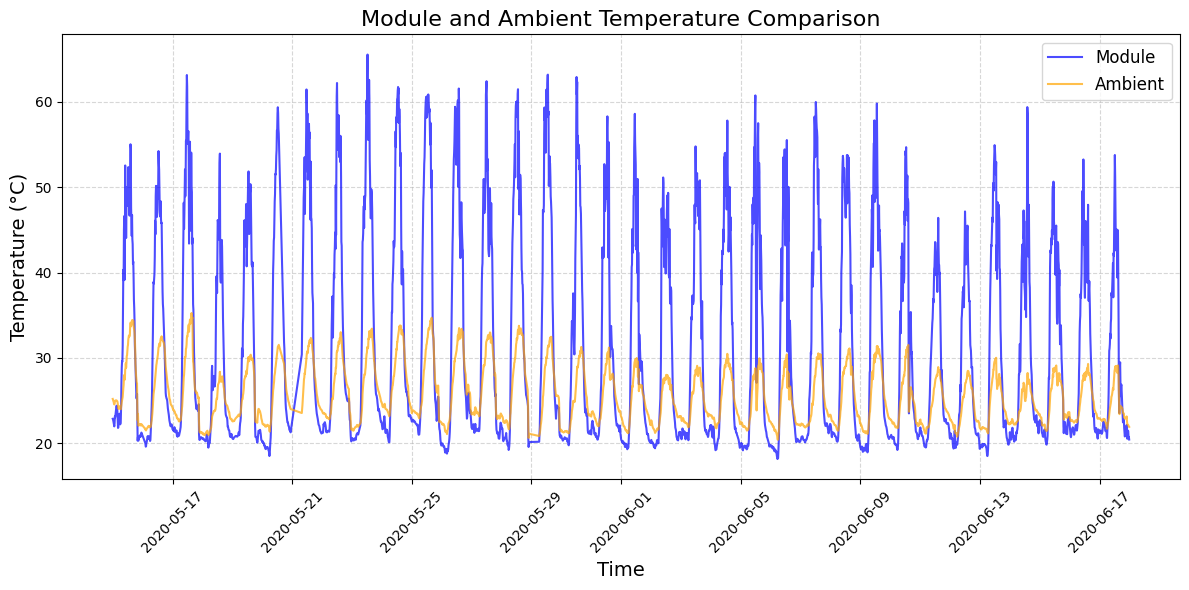

In [31]:
import matplotlib.pyplot as plt

def plot_temperature(df_plant1):
    plt.figure(figsize=(12, 6))

    # Plot Module and Ambient Temperature
    plt.plot(df_plant1['DATE_TIME'], df_plant1['MODULE_TEMPERATURE'], label="Module", color='blue', linestyle='-', alpha=0.7)
    plt.plot(df_plant1['DATE_TIME'], df_plant1['AMBIENT_TEMPERATURE'], label="Ambient", color='orange', linestyle='-',  alpha=0.7)

    # Add title and labels
    plt.title("Module and Ambient Temperature Comparison", fontsize=16)
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Temperature (°C)", fontsize=14)

    # Add grid and legend
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=12)

    # Rotate x-ticks for better readability
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

plot_temperature(df_plant1)

In [32]:
mod_amb_avg_diff = df_plant1['MODULE_TEMPERATURE'].mean() - df_plant1['AMBIENT_TEMPERATURE'].mean()
print(f"Average temperature difference between module and ambient: {mod_amb_avg_diff:.2f}°C")
mod_amb_max_diff = df_plant1['MODULE_TEMPERATURE'].max() - df_plant1['AMBIENT_TEMPERATURE'].max()
print(f"Maximum temperature difference between module and ambient: {mod_amb_max_diff:.2f}°C")

Average temperature difference between module and ambient: 5.69°C
Maximum temperature difference between module and ambient: 30.29°C


### Inverter wise analysis

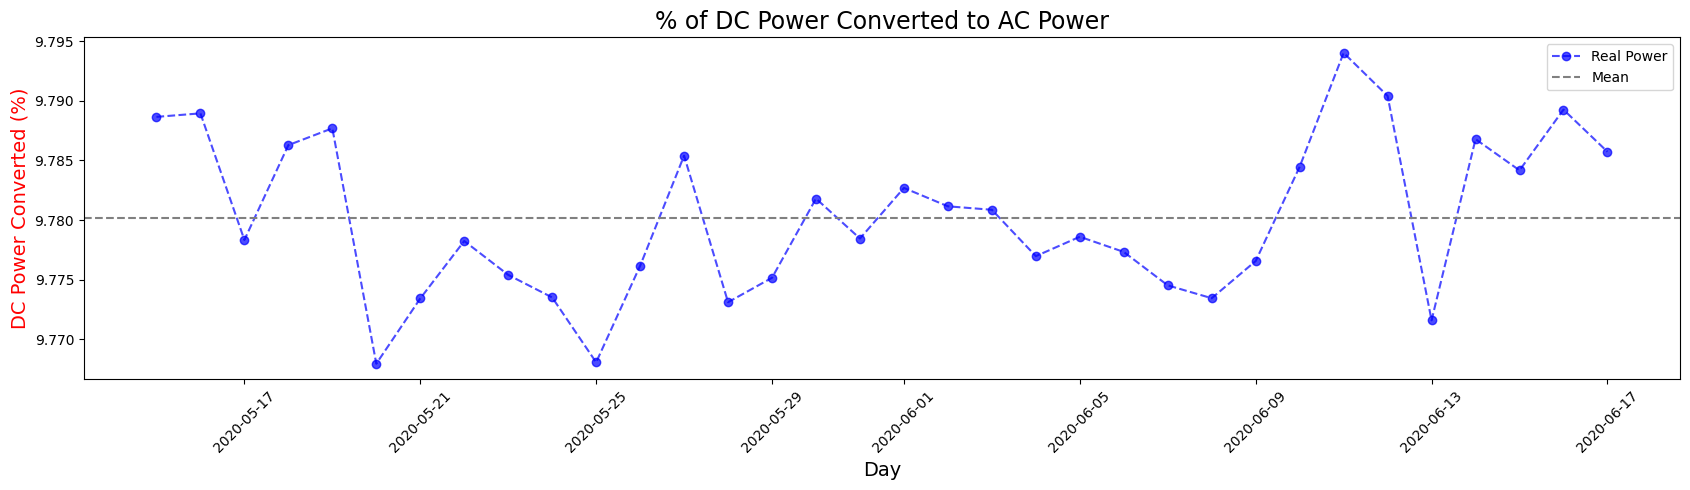

In [33]:
def plot_inverter_loss(df_plant1):
    # Create a copy of the DataFrame
    loss_df = df_plant1.copy()

    # Extract the date and group by day
    loss_df['Day'] = pd.to_datetime(loss_df['DATE_TIME']).dt.date
    loss_df = loss_df.groupby('Day').sum(numeric_only=True)

    # Calculate inverter loss
    loss_df['inverter_loss'] = (loss_df['AC_POWER'] / loss_df['DC_POWER']) * 100

    # Plot inverter loss
    plt.figure(figsize=(17, 5))
    loss_df['inverter_loss'].plot(style='o--', label='Real Power', color='blue', alpha=0.7)

    # Plot mean line
    plt.axhline(loss_df['inverter_loss'].mean(), linestyle='--', color='gray', label='Mean')

    # Add titles and labels
    plt.title('% of DC Power Converted to AC Power', fontsize=17)
    plt.ylabel('DC Power Converted (%)', fontsize=14, color='red')
    plt.xlabel('Day', fontsize=14)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_inverter_loss(df_plant1)

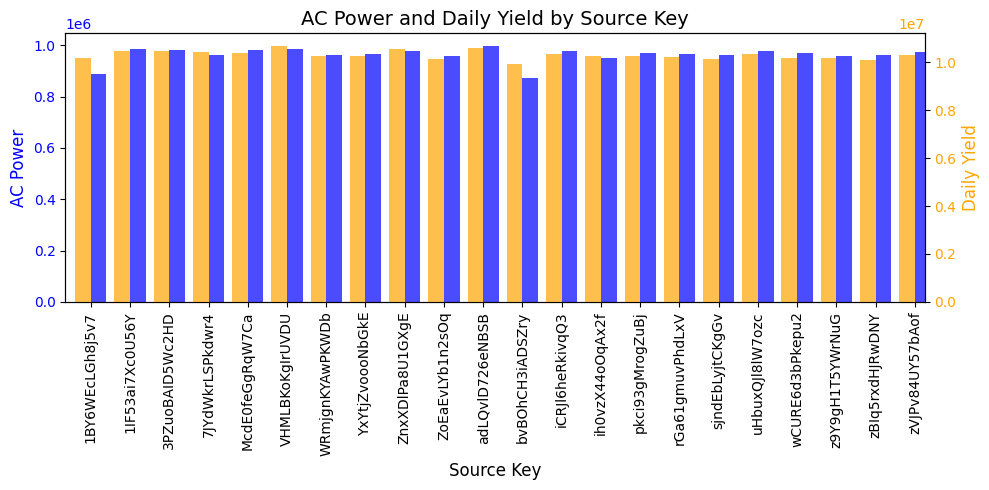

In [34]:
import matplotlib.pyplot as plt

# Group data
ac_power = df_plant1.groupby('SOURCE_KEY')[['AC_POWER', 'DAILY_YIELD']].sum()

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot AC_POWER on the first y-axis
ac_power['AC_POWER'].plot(kind='bar', ax=ax1, color='blue', position=0, width=0.4, label='AC Power', alpha=0.7)
ax1.set_ylabel('AC Power', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot DAILY_YIELD on the second y-axis
ac_power['DAILY_YIELD'].plot(kind='bar', ax=ax2, color='orange', position=1, width=0.4, label='Daily Yield', alpha=0.7)
ax2.set_ylabel('Daily Yield', color='orange', fontsize=12)
ax2.tick_params(axis='y', labelcolor='orange')

# Set title and labels
plt.title('AC Power and Daily Yield by Source Key', fontsize=14)
ax1.set_xlabel('Source Key', fontsize=12)

# Adjust layout
fig.tight_layout()

plt.show()

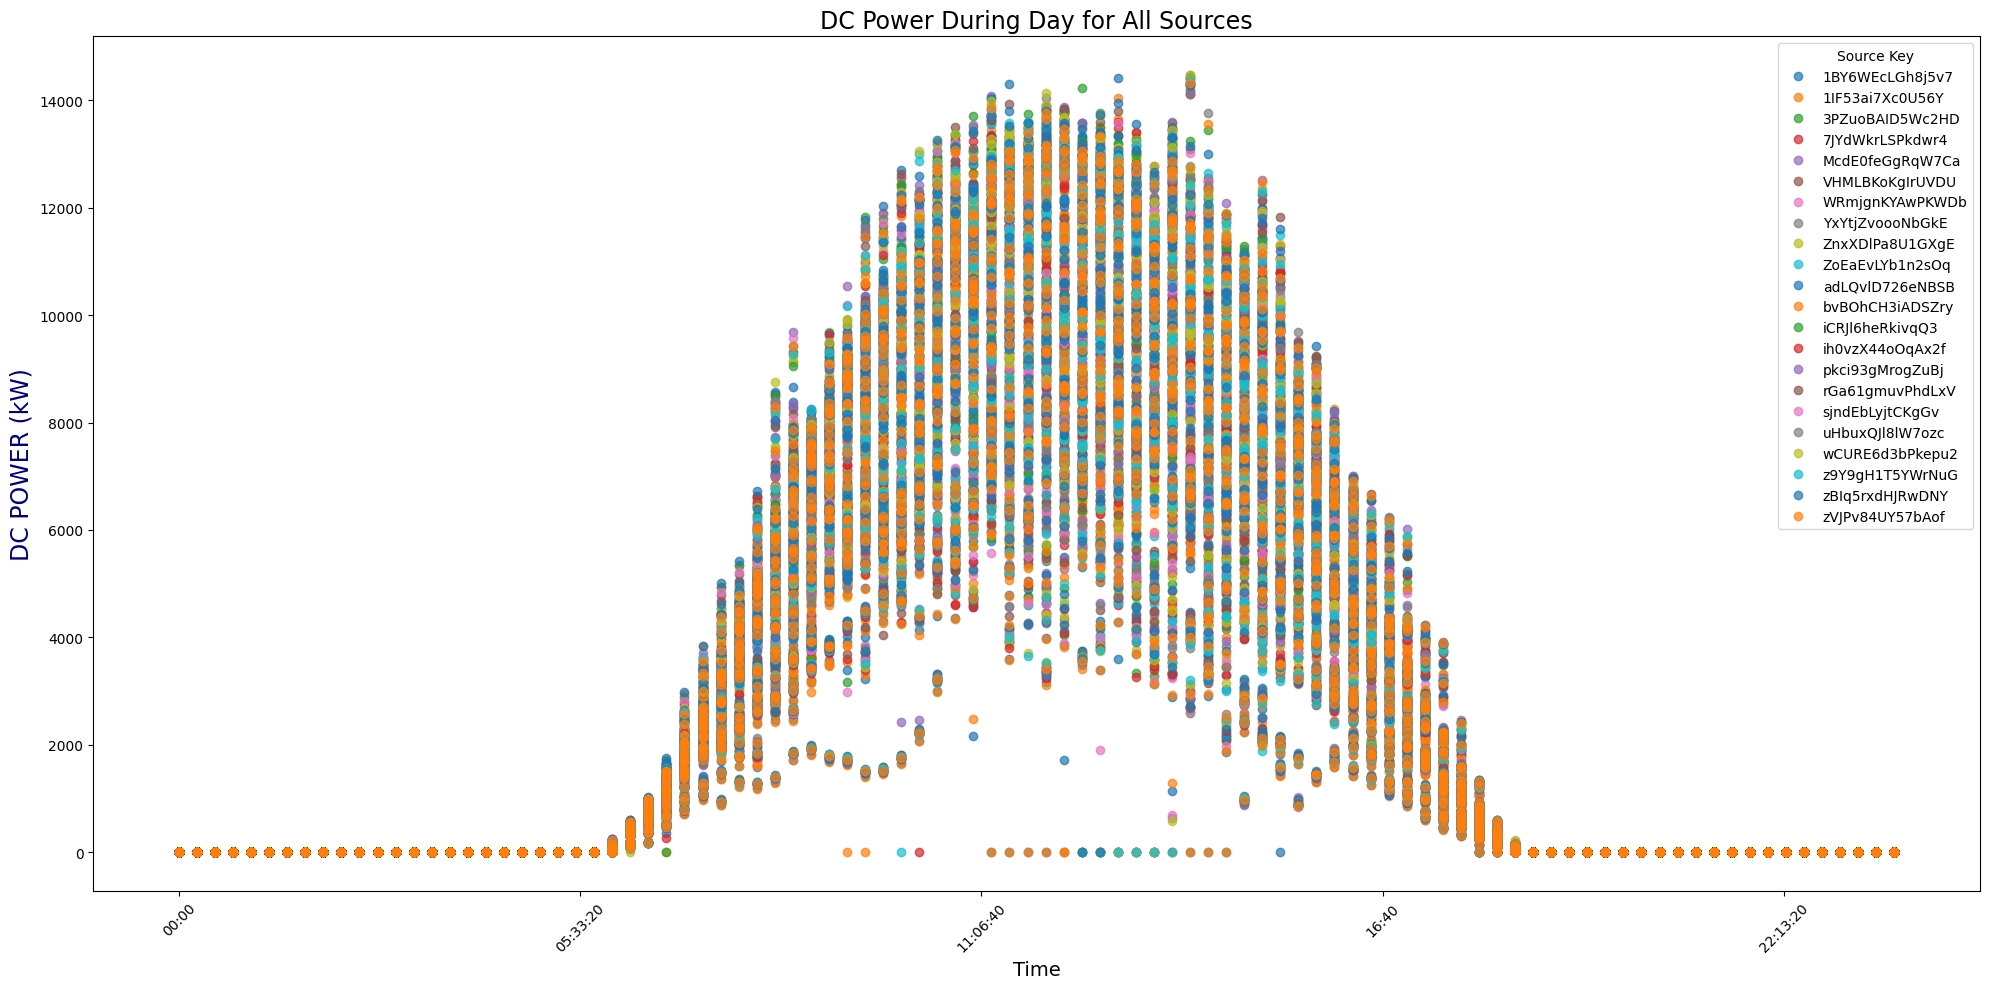

In [35]:
def plot_dc_power_by_source(gen_1):
    # Create a copy of the DataFrame
    sources = gen_1.copy()

    # Extract time from DATE_TIME
    sources['time'] = pd.to_datetime(sources['DATE_TIME']).dt.time

    # Plot DC Power for each source
    plt.figure(figsize=(20, 10))
    for key, group in sources.groupby('SOURCE_KEY'):
        group.set_index('time')['DC_POWER'].plot(style='o', label=key, alpha=0.7)

    # Add title and labels
    plt.title('DC Power During Day for All Sources', fontsize=17)
    plt.ylabel('DC POWER (kW)', color='navy', fontsize=17)
    plt.xlabel('Time', fontsize=14)
    plt.legend(title='Source Key')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_dc_power_by_source(df_plant1)

#### Next Step: Faulty Inverter Identification

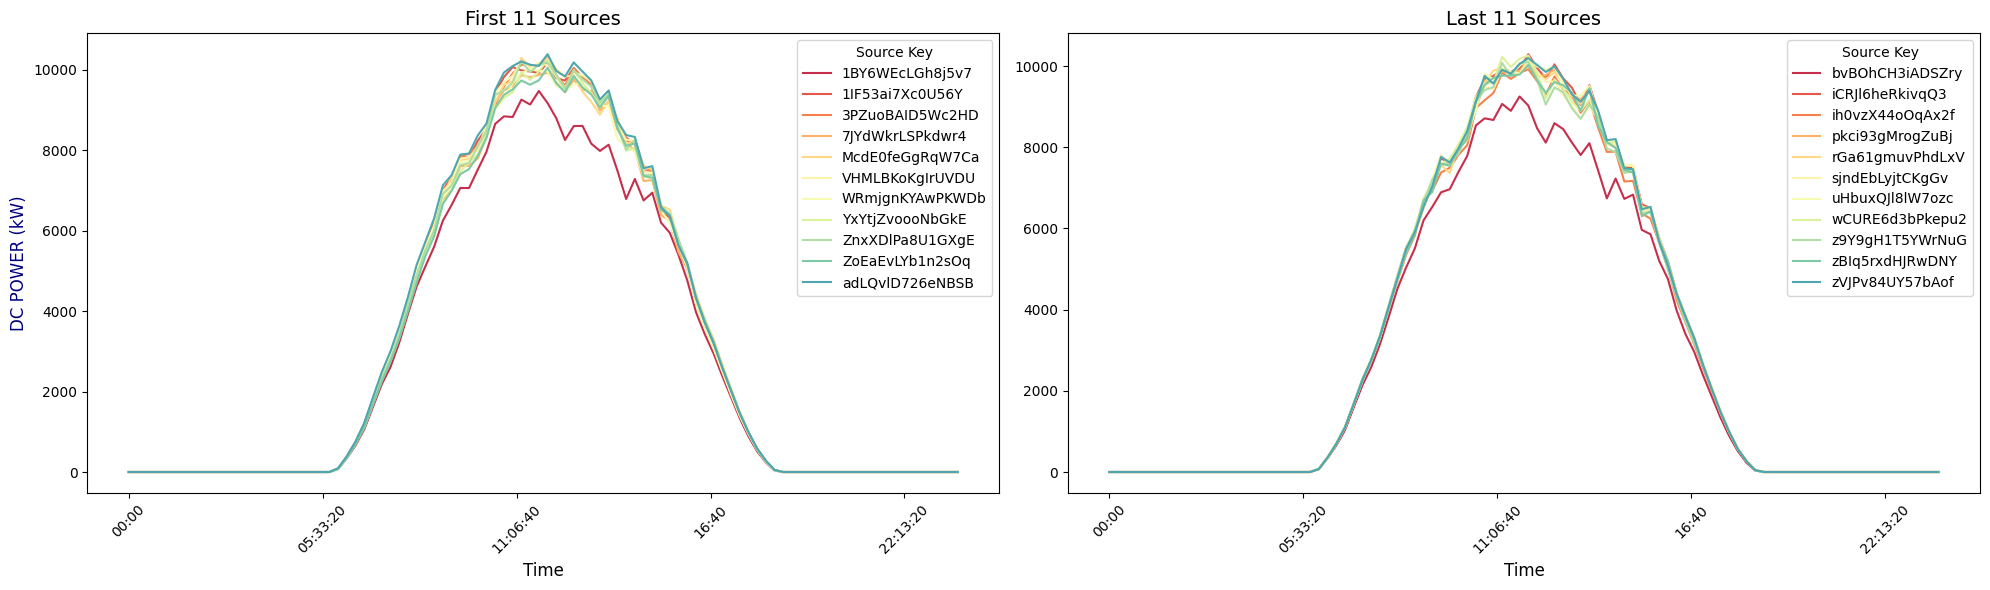

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_dc_power_by_source(gen_1):
    # Create a copy of the DataFrame
    dc_gen = gen_1.copy()

    # Extract time from DATE_TIME
    dc_gen['time'] = pd.to_datetime(dc_gen['DATE_TIME']).dt.time

    # Group by time and SOURCE_KEY, then calculate mean
    dc_gen = dc_gen.groupby(['time', 'SOURCE_KEY'])['DC_POWER'].mean().unstack()

    # Define color palette
    cmap = sns.color_palette("Spectral", n_colors=12)

    # Create subplots
    fig, ax = plt.subplots(ncols=2, nrows=1, dpi=100, figsize=(20, 6))

    # Plot first 11 sources
    dc_gen.iloc[:, 0:11].plot(ax=ax[0], color=cmap)
    ax[0].set_title('First 11 Sources', fontsize=14)
    ax[0].set_ylabel('DC POWER (kW)', fontsize=12, color='navy')
    ax[0].set_xlabel('Time', fontsize=12)
    ax[0].tick_params(axis='x', rotation=45)
    ax[0].legend(title='Source Key', fontsize=10)

    # Plot last 11 sources
    dc_gen.iloc[:, 11:22].plot(ax=ax[1], color=cmap)
    ax[1].set_title('Last 11 Sources', fontsize=14)
    ax[1].set_xlabel('Time', fontsize=12)
    ax[1].tick_params(axis='x', rotation=45)
    ax[1].legend(title='Source Key', fontsize=10)

    # Adjust layout
    plt.tight_layout()
    plt.show()
plot_dc_power_by_source(df_plant1)


It's evident that inverters 1BY6WEcLGh8j5v7 and bvBOhCH3iADSZry are not performing as well as the others, which may indicate the need for maintenance or replacement. However, before focusing solely on these underperforming units, let's first examine the common issues affecting the entire plant by analyzing the DC power generation during daylight hours over the 34-day period.

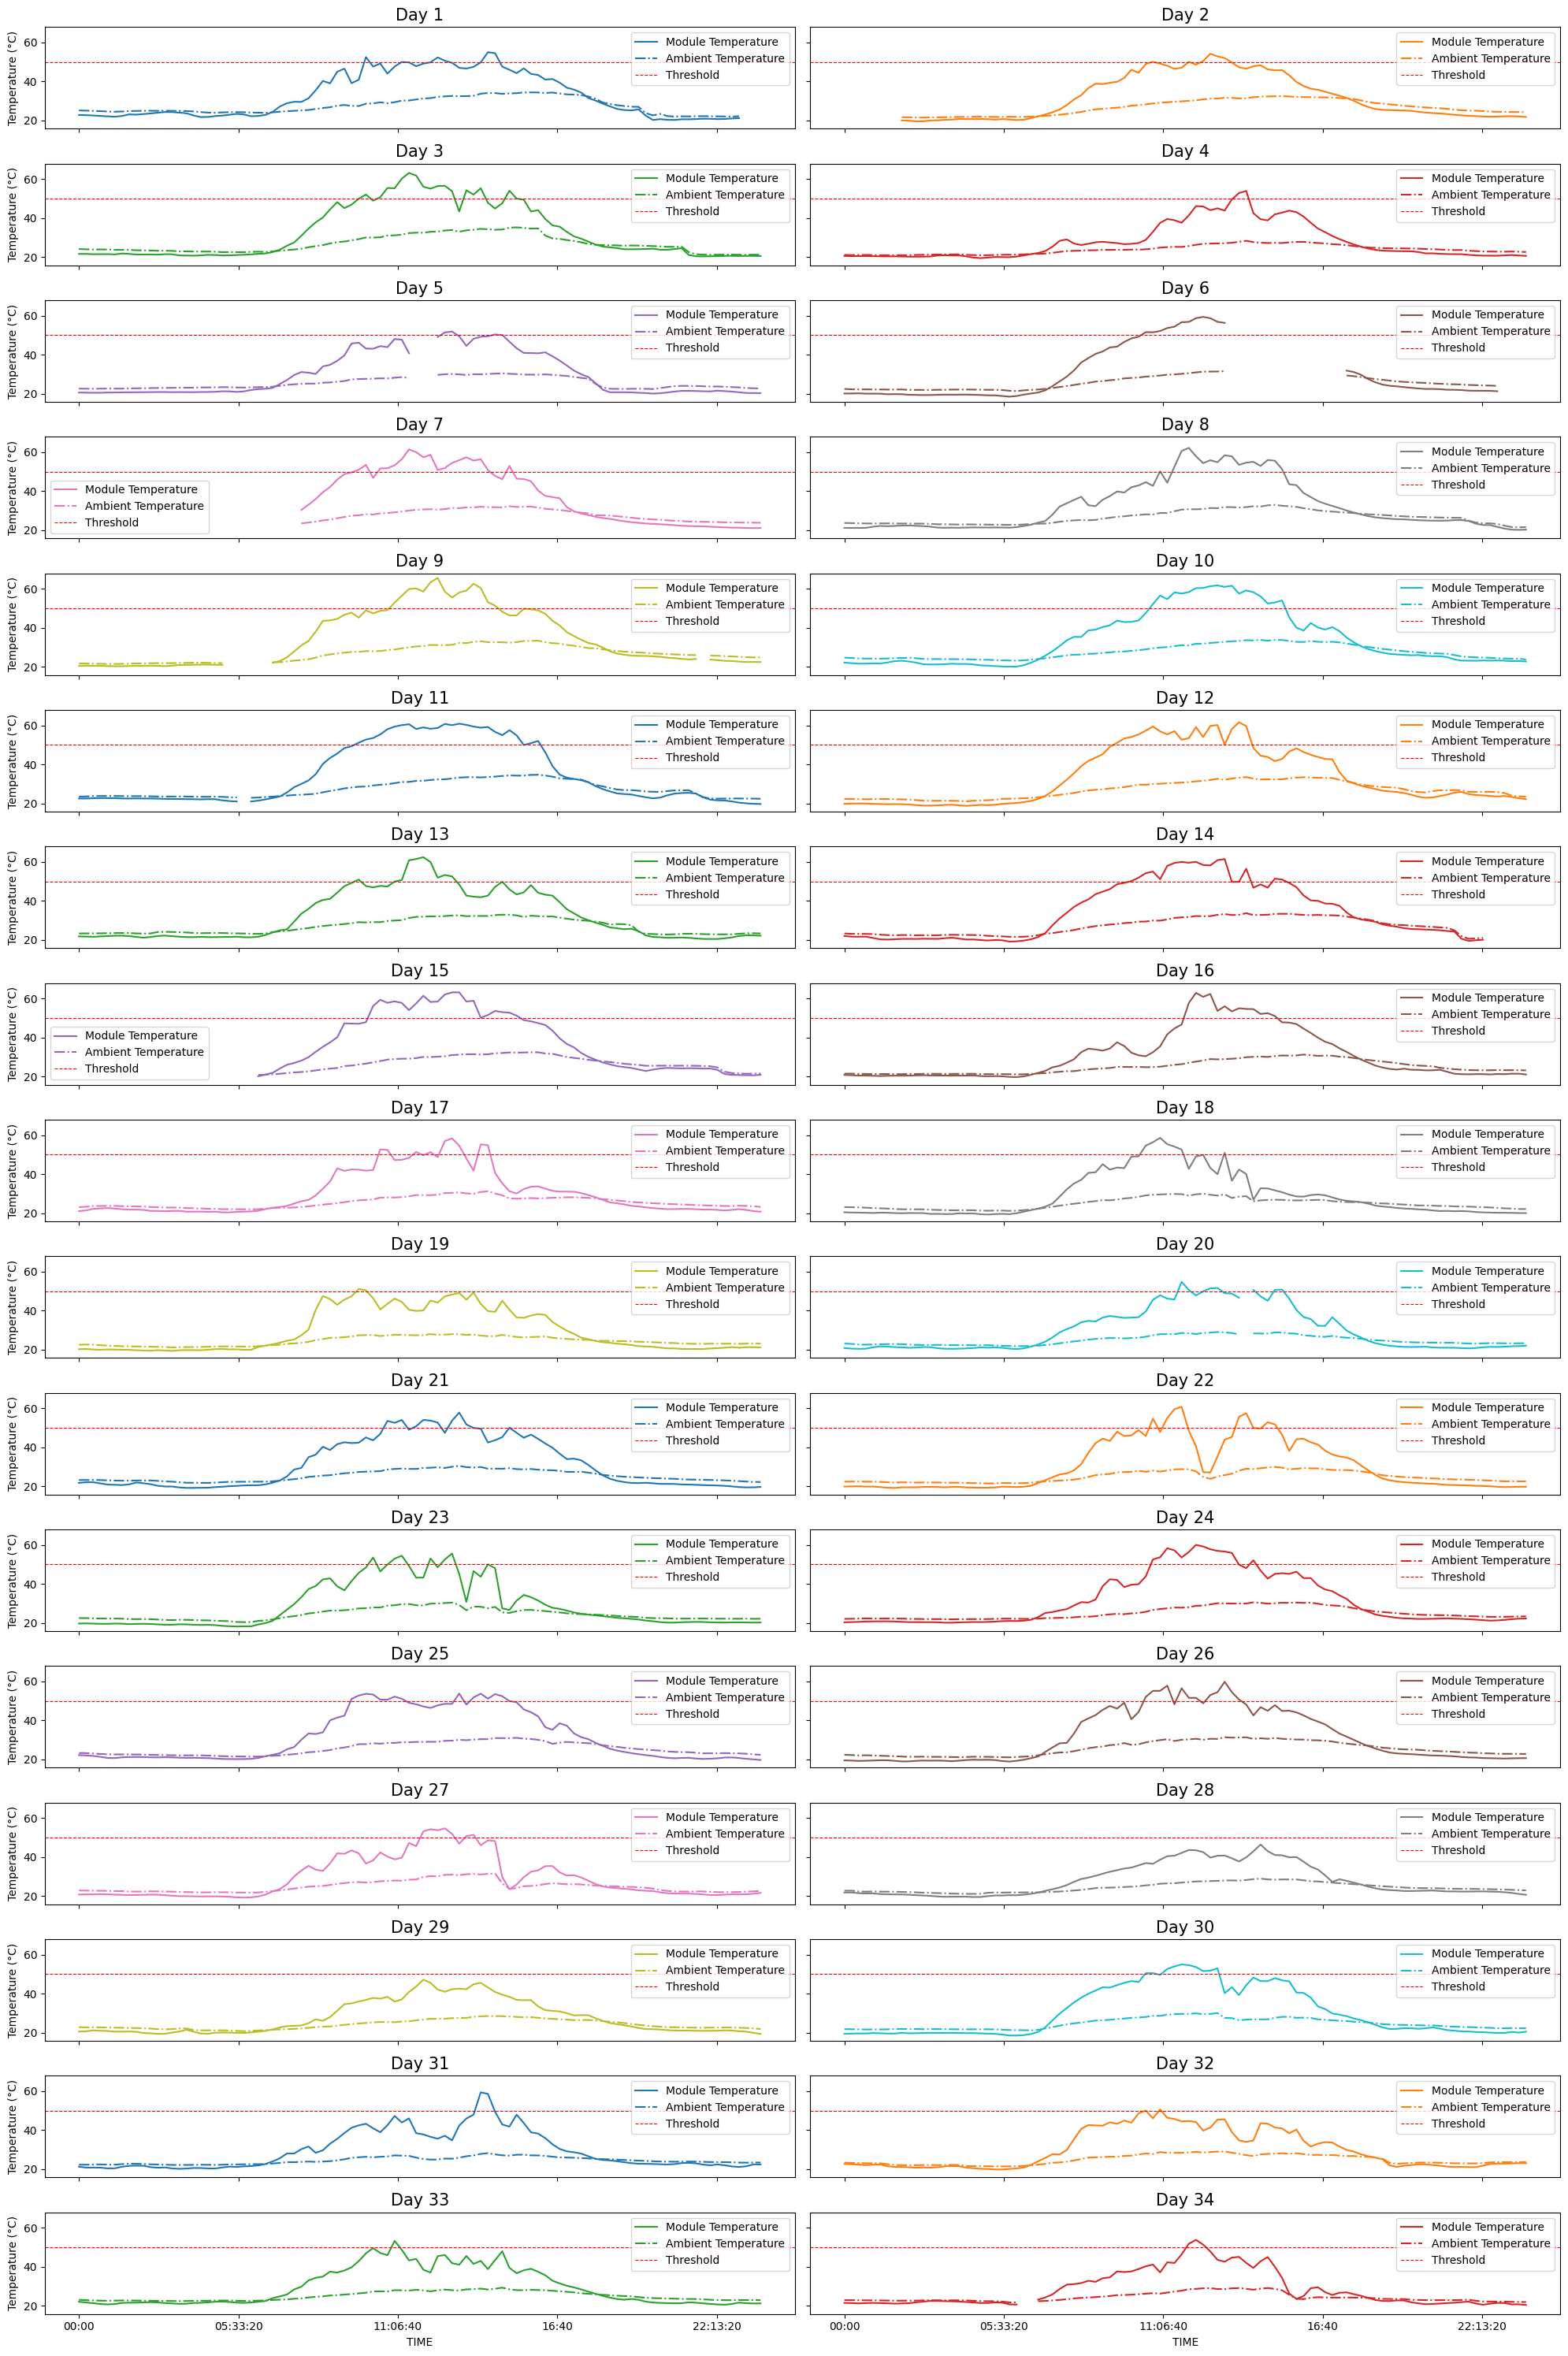

In [37]:
import matplotlib.pyplot as plt

def plot_temperatures(temp1_sens):
    # Group and plot Module Temperature
    ax = temp1_sens.groupby(['TIME','DATE'])['MODULE_TEMPERATURE'].mean().unstack().plot(
        subplots=True, layout=(17, 2), figsize=(20, 30), sharex=True, sharey=True, legend=False
    )

    # Group and plot Ambient Temperature on the same axes
    temp1_sens.groupby(['TIME', 'DATE'])['AMBIENT_TEMPERATURE'].mean().unstack().plot(
        subplots=True, layout=(17, 2), figsize=(20, 30), style='-.', ax=ax, legend=False
    )

    # Customize each subplot
    for i, ax_row in enumerate(ax):
        for j, ax_col in enumerate(ax_row):
            ax_col.axhline(50, color='red', linestyle='--', linewidth=0.8, label='Threshold')
            ax_col.set_title(f'Day {i * 2 + j + 1}', fontsize=15)
            ax_col.set_ylabel('Temperature (°C)')
            ax_col.legend(['Module Temperature', 'Ambient Temperature', 'Threshold'])

    plt.tight_layout()
    plt.show()

plot_temperatures(df_plant1)

It seems that the plant was non-operational during this period, likely due to a technical issue. A small drop in ambient temperature can significantly impact module temperature, which may explain the underperformance. By analyzing when module temperatures exceed 50 degrees, we can better understand whether a potential overload is affecting inverter performance.

### Fault Detection

In [38]:
import datetime
def time_in_range(start, end, x):
    """Return True if x is in the range [start, end], considering wrap-around."""
    # Check if the time range wraps around midnight
    if start <= end:
        return start <= x <= end
    else:
        return start <= x or x <= end

# Define normal daytime operation range
start = datetime.time(6, 30, 0)  # Sunrise
end = datetime.time(17, 30, 0)   # Sunset

# Create a new column to check proper operation status
# "Normal" if operation is normal, "Fault" if operation is faulty
df_plant1['STATUS'] = df_plant1.apply(lambda row: "Fault" if time_in_range(start, end, row['TIME']) and row['DC_POWER'] == 0 else "Normal", axis=1)
df_plant1.head()

DATE_TIME       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0 2020-05-15  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6259559.0   
1 2020-05-15  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6183645.0   
2 2020-05-15  3PZuoBAID5Wc2HD       0.0       0.0          0.0    6987759.0   
3 2020-05-15  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7602960.0   
4 2020-05-15  McdE0feGgRqW7Ca       0.0       0.0          0.0    7158964.0   

   AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  SENSOR_NUM  \
0            25.184316           22.857507          0.0           1   
1            25.184316           22.857507          0.0           2   
2            25.184316           22.857507          0.0           3   
3            25.184316           22.857507          0.0           4   
4            25.184316           22.857507          0.0           5   

  SENSOR_NAME        DATE      TIME  HOURS  MINUTES  MINUTES_PASS    DATE_STR  \
0           1  2020-05-15  00:00:00      0        0             0  2020-05-15   
1           2  2020-05-15  00:00:00      0        0             0  2020-05-15   
2           3  2020-05-15  00:00:00      0        0             0  2020-05-15   
3           4  2020-05-15  00:00:00      0        0             0  2020-05-15   
4           5  2020-05-15  00:00:00      0        0             0  2020-05-15   

         date  STATUS  
0  2020-05-15  Normal  
1  2020-05-15  Normal  
2  2020-05-15  Normal  
3  2020-05-15  Normal  
4  2020-05-15  Normal

In [39]:
df_plant1['STATUS'].value_counts()

STATUS
Normal    68709
Fault        65
Name: count, dtype: int64

In [40]:
fault_count = df_plant1['STATUS'].value_counts().get('Fault', 0)

# Print the result
print(f"There are {fault_count} records of faulty operation!")

There are 65 records of faulty operation!


#### Days with faults

In [41]:
df_plant1[df_plant1["STATUS"]== "Fault"]["DATE"].value_counts()

DATE
2020-06-07    32
2020-06-14    24
2020-05-15     2
2020-06-16     2
2020-06-17     2
2020-05-24     1
2020-05-25     1
2020-06-09     1
Name: count, dtype: int64

#### Inverter fault operations

In [42]:
faulty_sources = df_plant1.query("STATUS == 'Fault'")["SOURCE_KEY"].value_counts()
print(faulty_sources)

SOURCE_KEY
bvBOhCH3iADSZry    21
1BY6WEcLGh8j5v7    19
z9Y9gH1T5YWrNuG     7
wCURE6d3bPkepu2     5
zBIq5rxdHJRwDNY     3
McdE0feGgRqW7Ca     3
sjndEbLyjtCKgGv     3
zVJPv84UY57bAof     2
ih0vzX44oOqAx2f     1
iCRJl6heRkivqQ3     1
Name: count, dtype: int64


In [43]:
import plotly.express as px

# Convert the Series (result of value_counts) to a DataFrame
faulty_sources_df = faulty_sources.reset_index()

# Rename columns for clarity
faulty_sources_df.columns = ['Inverter', 'Faults']

# Create the bar plot
fig = px.bar(
    faulty_sources_df,
    x='Inverter',
    y='Faults',
    title="Inverter Faults",
    labels={"Inverter": "Inverter", "Faults": "Faults"}
)

# Update layout for better aesthetics
fig.update_layout(showlegend=False, xaxis_title="Inverter", yaxis_title="Faults", template="plotly_white")

# Display the figure
fig.show()


### SUMMARY

In [44]:
print("The most faults were recorded on {} and {}." .format(df_plant1[df_plant1["STATUS"]== "Fault"]["DATE"].value_counts().index[0], df_plant1[df_plant1["STATUS"]== "Fault"]["DATE"].value_counts().index[1]))
print("Inverter {} and {} had the most failures." .format(df_plant1[df_plant1["STATUS"]== "Fault"]["SOURCE_KEY"].value_counts().index[0],df_plant1[df_plant1["STATUS"]== "Fault"]["SOURCE_KEY"].value_counts().index[1]))

The most faults were recorded on 2020-06-07 and 2020-06-14.
Inverter bvBOhCH3iADSZry and 1BY6WEcLGh8j5v7 had the most failures.


### FORECASTING

### METHOD 1: LSTM

#### Approach to Model the Forecasting Model

##### What we will do?

We will take the `DAILY_YIELD` data from the first 60 minutes as input in the `X` array, and the corresponding output for this `X` array will be `Y`, which represents the `DAILY_YIELD` at the 75th minute. For the next step, we will take the `DAILY_YIELD` data for the next 60 minutes as input, and the output will be the `DAILY_YIELD` at the 75th minute.

This sliding window approach will continue by shifting the window forward, allowing the model to learn how the yield changes over time and make predictions for future time intervals.

### Example:
- **First window:** `X = [[yield_00], [yield_15], ..., [yield_60]], Y = [yield_75]`
- **Second window:** `X = [[yield_15], [yield_30], ..., [yield_75]], Y = [yield_90]`
- **Third window:** `X = [[yield_30], [yield_45], ..., [yield_90]], Y = [yield_105]`

This method helps to capture the temporal dependencies in `DAILY_YIELD` over time, which is crucial for accurate yield forecasting.


In [45]:
df = gen_1.copy()
df.head()

DATE_TIME  PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  \
0  15-05-2020 00:00   4135001  1BY6WEcLGh8j5v7       0.0       0.0   
1  15-05-2020 00:00   4135001  1IF53ai7Xc0U56Y       0.0       0.0   
2  15-05-2020 00:00   4135001  3PZuoBAID5Wc2HD       0.0       0.0   
3  15-05-2020 00:00   4135001  7JYdWkrLSPkdwr4       0.0       0.0   
4  15-05-2020 00:00   4135001  McdE0feGgRqW7Ca       0.0       0.0   

   DAILY_YIELD  TOTAL_YIELD  
0          0.0    6259559.0  
1          0.0    6183645.0  
2          0.0    6987759.0  
3          0.0    7602960.0  
4          0.0    7158964.0

In [46]:
# Step 1: Convert 'DATE_TIME' to a datetime object
df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'], format='%d-%m-%Y %H:%M')

# Step 2: Set 'DATE_TIME' as the index
df.set_index('DATE_TIME', inplace=True)

# Step 3: Resample the data into 15-minute intervals and sum the values over each interval
df_resampled = df.resample('15T').sum()


In [47]:
df_resampled['DAILY_YIELD_MW'] = df_resampled['DAILY_YIELD']/1000
df_resampled.head()

PLANT_ID  \
DATE_TIME                       
2020-05-15 00:00:00  86835021   
2020-05-15 00:15:00  86835021   
2020-05-15 00:30:00  86835021   
2020-05-15 00:45:00  86835021   
2020-05-15 01:00:00  90970022   

                                                            SOURCE_KEY  \
DATE_TIME                                                                
2020-05-15 00:00:00  1BY6WEcLGh8j5v71IF53ai7Xc0U56Y3PZuoBAID5Wc2HD7...   
2020-05-15 00:15:00  1BY6WEcLGh8j5v71IF53ai7Xc0U56Y3PZuoBAID5Wc2HD7...   
2020-05-15 00:30:00  1BY6WEcLGh8j5v71IF53ai7Xc0U56Y3PZuoBAID5Wc2HD7...   
2020-05-15 00:45:00  1BY6WEcLGh8j5v71IF53ai7Xc0U56Y3PZuoBAID5Wc2HD7...   
2020-05-15 01:00:00  1BY6WEcLGh8j5v71IF53ai7Xc0U56Y3PZuoBAID5Wc2HD7...   

                     DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
DATE_TIME                                                           
2020-05-15 00:00:00       0.0       0.0          0.0  143581676.0   
2020-05-15 00:15:00       0.0       0.0          0.0  143581676.0   
2020-05-15 00:30:00       0.0       0.0          0.0  143581676.0   
2020-05-15 00:45:00       0.0       0.0          0.0  143581676.0   
2020-05-15 01:00:00       0.0       0.0          0.0  150761642.0   

                     DAILY_YIELD_MW  
DATE_TIME                            
2020-05-15 00:00:00             0.0  
2020-05-15 00:15:00             0.0  
2020-05-15 00:30:00             0.0  
2020-05-15 00:45:00             0.0  
2020-05-15 01:00:00             0.0

In [48]:
daily_yield = df_resampled['DAILY_YIELD_MW']
daily_yield.head(20)
daily_yield.shape

(3264,)

In [49]:
# Making a function to execute above idea

def df_to_X_y(df, window_size=5):  # 5 here means we are taking the last 5 values
    df_as_np = df.to_numpy() #converting the dataframe to numpy arrays
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

In [50]:
WINDOW_SIZE = 5
X, y = df_to_X_y(daily_yield, WINDOW_SIZE)
X.shape, y.shape

((3259, 5, 1), (3259,))

#### TRAIN, VALIDATION AND TEST DATASET SPLITTING

In [51]:
# making a train and test dataset to train the model

X_train, y_train  = X[:2600], y[:2600]
X_val, y_val  = X[2600:2900], y[2600:2900]
X_test, y_test  = X[2900:], y[2900:]

In [52]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(2600, 5, 1) (2600,)
(300, 5, 1) (300,)
(359, 5, 1) (359,)


In [53]:
#  Tensorflow imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, InputLayer, Dropout

# Defining the model and adding layers into the LSTM model
model1 = Sequential()

# Assuming input shape of (5, 1) for 60 minutes of daily yield data
model1.add(InputLayer(input_shape=(5, 1)))  # 5 time steps, 1 feature

# LSTM layer with 32 units, reduced from 64 to prevent overfitting
model1.add(LSTM(32))

# Adding a Dense layer with 8 units and ReLU activation
model1.add(Dense(8, activation='relu'))

# Adding Dropout for regularization (optional, 0.2 means 20% dropout rate)
model1.add(Dropout(0.2))

# Output layer for a single value prediction with linear activation
model1.add(Dense(1, activation='linear'))

# Compile the model
model1.compile(optimizer='adam', loss='mse')

# Model summary to check the architecture
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,625 (18.07 KB)

 Trainable params: 4,625 (18.07 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError

# Define the model checkpoint callback
# Save the best model based on validation loss (lowest RMSE)
cp = ModelCheckpoint(
    filepath='model1/best_model.keras',  # Use .h5 extension for model saving
    monitor='val_root_mean_squared_error',  # Monitor validation RMSE
    save_best_only=True,
    save_weights_only=False,  # Save full model instead of just weights
    verbose=1  # Print out saving messages
)

# Add early stopping to stop training if the model stops improving
es = EarlyStopping(
    monitor='val_root_mean_squared_error',  # Stop if RMSE doesn't improve
    patience=10,  # Wait 10 epochs before stopping
    restore_best_weights=True,  # Restore the best weights after stopping
    verbose=1
)

# Compile the model
# Lower learning rate is set to help the optimizer converge more smoothly
model1.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(learning_rate=1e-4),  # 0.0001 is written as 1e-4 for clarity
    metrics=[RootMeanSquaredError()]  # RMSE metric for model evaluation
)


In [55]:
# Fit the model with better structure, additional callbacks, and dynamic batch size
model1.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),  # Provide validation data for real-time evaluation
    epochs=75,  # Increase epochs for a more robust model, can be adjusted later
    batch_size=32,  # Use a moderate batch size (adjust based on your hardware)
    callbacks=[cp, es],  # Include EarlyStopping for better convergence
    verbose=1  # Show training progress
)

Epoch 1/75
76/82 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9230.5312 - root_mean_squared_error: 96.0622 
Epoch 1: val_root_mean_squared_error improved from inf to 93.61801, saving model to model1/best_model.keras
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 9226.8613 - root_mean_squared_error: 96.0442 - val_loss: 8764.3320 - val_root_mean_squared_error: 93.6180
Epoch 2/75
79/82 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8785.5205 - root_mean_squared_error: 93.7036
Epoch 2: val_root_mean_squared_error improved from 93.61801 to 93.31876, saving model to model1/best_model.keras
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8800.8936 - root_mean_squared_error: 93.7862 - val_loss: 8708.3896 - val_root_mean_squared_error: 93.3188
Epoch 3/75
80/82 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9022.2393 - root_mean_squared_error: 94.9726
Epoch 3: val_root_mean_squared_error improved from 93.31876 to 92.87112, saving model to model1/best_model.keras
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 

In [56]:
from tensorflow.keras.models import load_model

# Load the best saved model
model1 = load_model('model1/best_model.keras')  # Use the correct file extension and path

# Print model summary to confirm successful loading
model1.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,877 (54.21 KB)

 Trainable params: 4,625 (18.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,252 (36.14 KB)

##### TRAIN DATASET

In [57]:
# Make predictions on the training data
train_predictions = model1.predict(X_train).flatten()

# Create a DataFrame to compare predictions and actual values
train_results = pd.DataFrame({
    'Train Predictions': train_predictions,
    'Actual Values': y_train.flatten()  # Ensure y_train is also flattened for consistency
})

# Optionally display the first few rows of the DataFrame to verify
train_results.head()

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Train Predictions  Actual Values
0           0.767288            0.0
1           0.767288            0.0
2           0.767288            0.0
3           0.767288            0.0
4           0.767288            0.0

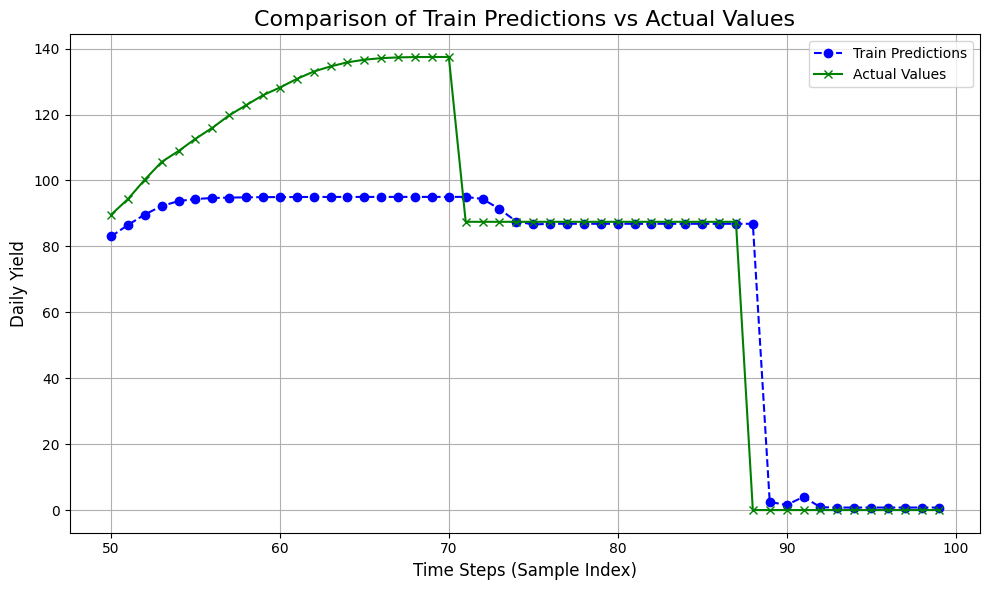

In [58]:
import matplotlib.pyplot as plt

# Set plot size for better visibility
plt.figure(figsize=(10, 6))

# Plot Train Predictions and Actual Values
plt.plot(train_results['Train Predictions'][50:100], label='Train Predictions', color='blue', linestyle='--', marker='o')
plt.plot(train_results['Actual Values'][50:100], label='Actual Values', color='green', linestyle='-', marker='x')

# Add labels, title, and grid
plt.title('Comparison of Train Predictions vs Actual Values', fontsize=16)
plt.xlabel('Time Steps (Sample Index)', fontsize=12)
plt.ylabel('Daily Yield', fontsize=12)
plt.grid(True)

# Add a legend to differentiate the lines
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


##### VALIDATION DATA

In [59]:
# Make predictions on the validation data
val_predictions = model1.predict(X_val).flatten()

# Create a DataFrame to compare predictions and actual values
val_results = pd.DataFrame({
    'Val Predictions': val_predictions,
    'Actual Values': y_val.flatten()  # Ensure y_val is flattened for consistency
})

# Display the DataFrame to check predictions vs actuals
val_results.head()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Val Predictions  Actual Values
0         0.767288            0.0
1         0.767288            0.0
2         0.767288            0.0
3         0.767288            0.0
4         0.767288            0.0

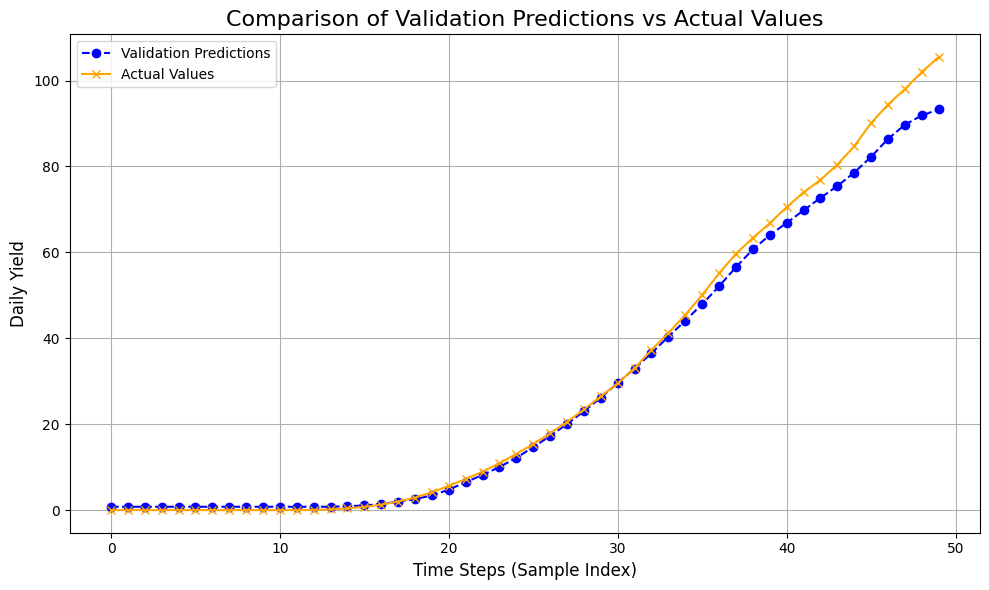

In [60]:
import matplotlib.pyplot as plt

# Set plot size for better visibility
plt.figure(figsize=(10, 6))

# Plot Validation Predictions and Actual Values
plt.plot(val_results['Val Predictions'][:50], label='Validation Predictions', color='blue', linestyle='--', marker='o')
plt.plot(val_results['Actual Values'][:50], label='Actual Values', color='orange', linestyle='-', marker='x')

# Add labels, title, and grid
plt.title('Comparison of Validation Predictions vs Actual Values', fontsize=16)
plt.xlabel('Time Steps (Sample Index)', fontsize=12)
plt.ylabel('Daily Yield', fontsize=12)
plt.grid(True)

# Add a legend to differentiate the lines
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


##### TEST DATASET

In [61]:
# Make predictions on the test data
test_predictions_1 = model1.predict(X_test).flatten()

# Create a DataFrame to compare predictions and actual values
test_results_1 = pd.DataFrame({
    'Test Predictions': test_predictions_1,
    'Actual Values': y_test.flatten()  # Ensure y_test is flattened for consistency
})

# Display the first few rows of the DataFrame
test_results_1.head()


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Test Predictions  Actual Values
0          0.768876       0.094214
1          0.827344       0.350036
2          1.023275       0.829661
3          1.599292       1.565268
4          2.498358       3.003446

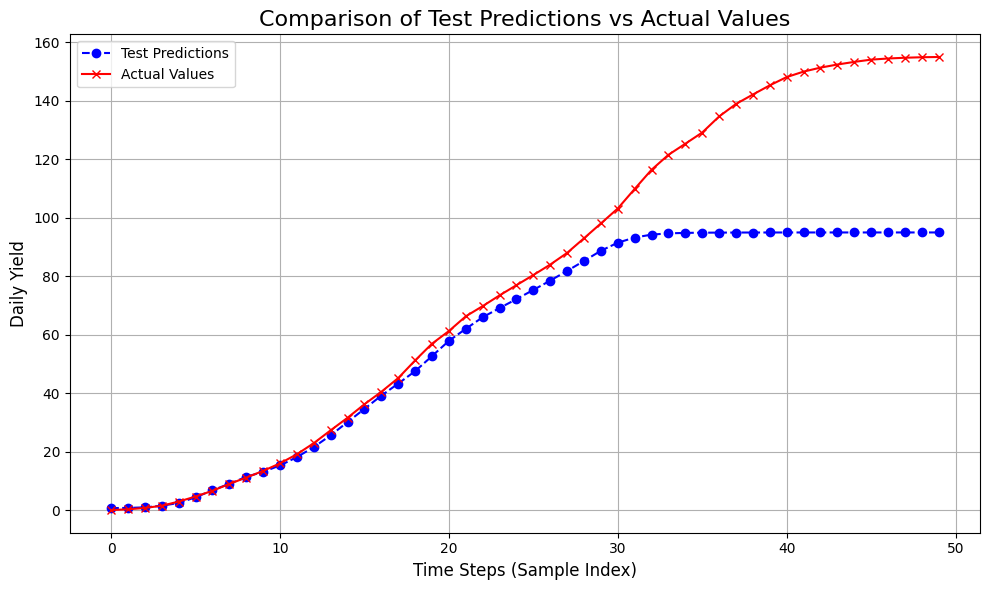

In [62]:
import matplotlib.pyplot as plt

# Set plot size for better visibility
plt.figure(figsize=(10, 6))

# Plot Test Predictions and Actual Values
plt.plot(test_results_1['Test Predictions'][:50], label='Test Predictions', color='blue', linestyle='--', marker='o')
plt.plot(test_results_1['Actual Values'][:50], label='Actual Values', color='red', linestyle='-', marker='x')

# Add labels, title, and grid
plt.title('Comparison of Test Predictions vs Actual Values', fontsize=16)
plt.xlabel('Time Steps (Sample Index)', fontsize=12)
plt.ylabel('Daily Yield', fontsize=12)
plt.grid(True)

# Add a legend to differentiate the lines
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

def evaluate_model_performance(y_true, y_pred):
    """
    Evaluates model performance by computing key metrics and generating visualizations.

    Parameters:
    y_true (array-like): Actual values
    y_pred (array-like): Predicted values

    Returns:
    dict: A dictionary containing calculated metrics (MSE, RMSE, MAE, R²)
    """

    # Flattening inputs if they are not 1D
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    # Calculating key metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Printing metrics
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Residuals calculation
    residuals = y_true - y_pred

    # Plotting residuals distribution
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(residuals, bins=20, edgecolor='black')
    plt.title('Residuals Distribution')
    plt.xlabel('Residual')
    plt.ylabel('Frequency')

    # Plotting Predictions vs Actual Values
    plt.subplot(1, 2, 2)
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.title('Predictions vs Actual Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')  # Ideal line

    plt.tight_layout()
    plt.show()

    # Plotting actual vs predicted over time (for time series or sequential data)
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='Actual Values')
    plt.plot(y_pred, label='Predicted Values', alpha=0.7)
    plt.title('Actual vs Predicted Values Over Time')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

    # Returning a dictionary of computed metrics
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }

    return metrics

Mean Squared Error (MSE): 923.9586
Root Mean Squared Error (RMSE): 30.3967
Mean Absolute Error (MAE): 20.6171
R² Score: 0.7520


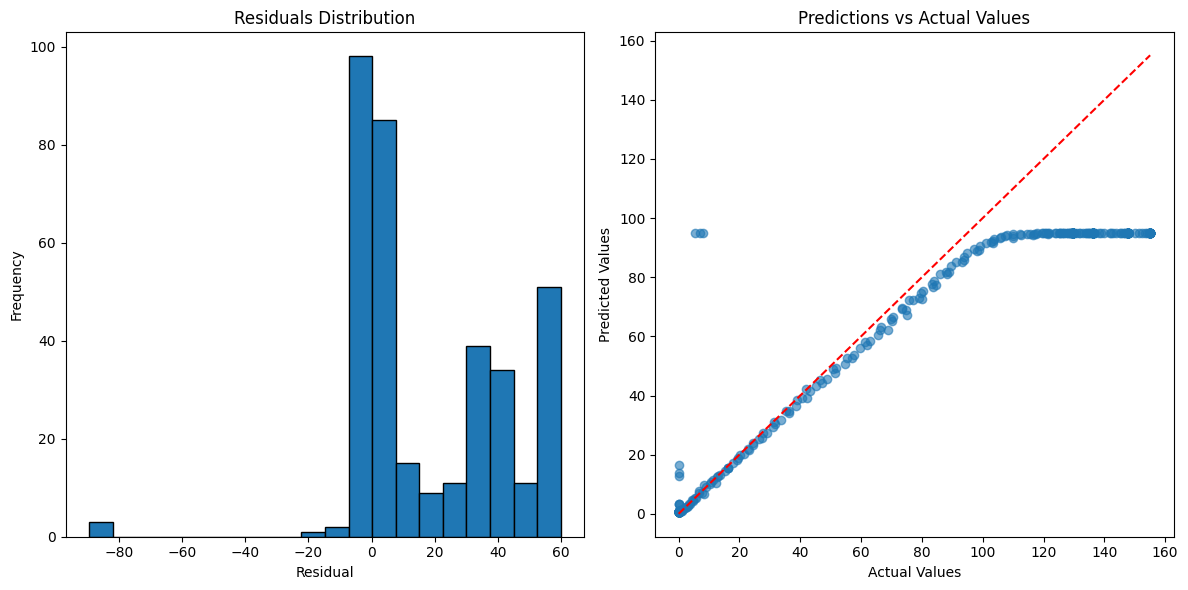

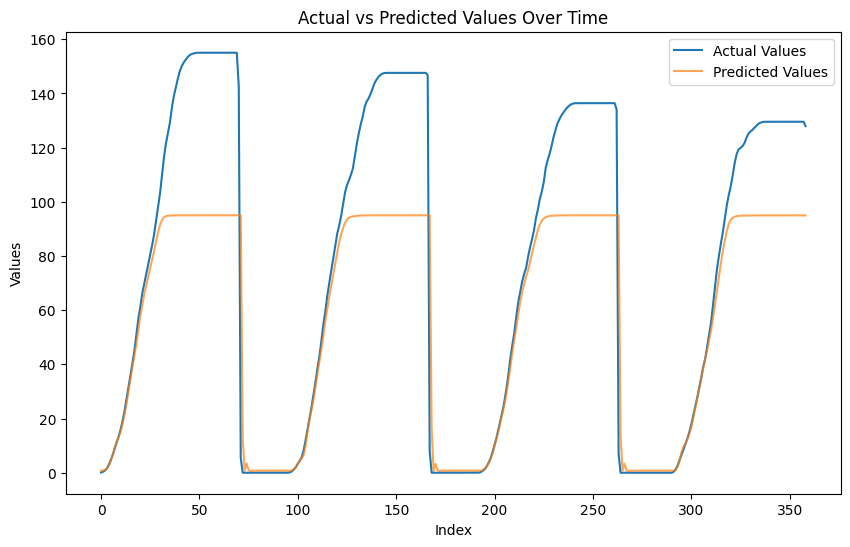

In [64]:
train_metrics_model1 = evaluate_model_performance(y_test, test_predictions_1)

In [65]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define Model
model2 = Sequential()

# Stacked LSTM Layers with Dropout
model2.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model2.add(Dropout(0.2))
model2.add(LSTM(64, return_sequences=False))
model2.add(Dropout(0.2))

# Dense Layers
model2.add(Dense(32, activation='relu'))
model2.add(Dense(1, activation='linear'))

# Compile the model
model2.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['RootMeanSquaredError'])

# Set callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('model2_best.keras', save_best_only=True, monitor='val_loss')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

# Fit the model
history = model2.fit(X_train, y_train,
                     validation_data=(X_val, y_val),
                     epochs=100,
                     batch_size=64,
                     callbacks=[early_stopping, checkpoint, lr_scheduler])

# Load the best model weights
model2.load_weights('model2_best.keras')


Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - RootMeanSquaredError: 94.8724 - loss: 9009.1357 - val_RootMeanSquaredError: 84.5683 - val_loss: 7151.7891 - learning_rate: 0.0010
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - RootMeanSquaredError: 83.4902 - loss: 6975.5269 - val_RootMeanSquaredError: 72.9787 - val_loss: 5325.8965 - learning_rate: 0.0010
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - RootMeanSquaredError: 73.1457 - loss: 5360.3887 - val_RootMeanSquaredError: 59.1928 - val_loss: 3503.7825 - learning_rate: 0.0010
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - RootMeanSquaredError: 56.6623 - loss: 3213.7593 - val_RootMeanSquaredError: 45.2453 - val_loss: 2047.1383 - learning_rate: 0.0010
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - RootMeanSquaredError: 45.7191 - loss: 2095.6211 - val_RootMeanSquaredError: 33.4864 - val_loss: 1121.3391 - learning_rate: 0.0010
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - RootMeanSquaredError: 33.7

In [69]:
# Print model summary to confirm successful loading
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 5, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 354,245 (1.35 MB)

 Trainable params: 118,081 (461.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 236,164 (922.52 KB)

In [66]:
# Make predictions on the test data
test_predictions_2 = model2.predict(X_test).flatten()

# Create a DataFrame to compare predictions and actual values
test_results_2 = pd.DataFrame({
    'Test Predictions': test_predictions_2,
    'Actual Values': y_test.flatten()  # Ensure y_test is flattened for consistency
})

# Display the first few rows of the DataFrame
test_results_2.head()

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


Test Predictions  Actual Values
0          0.158243       0.094214
1          0.190022       0.350036
2          0.351188       0.829661
3          0.968434       1.565268
4          2.024354       3.003446

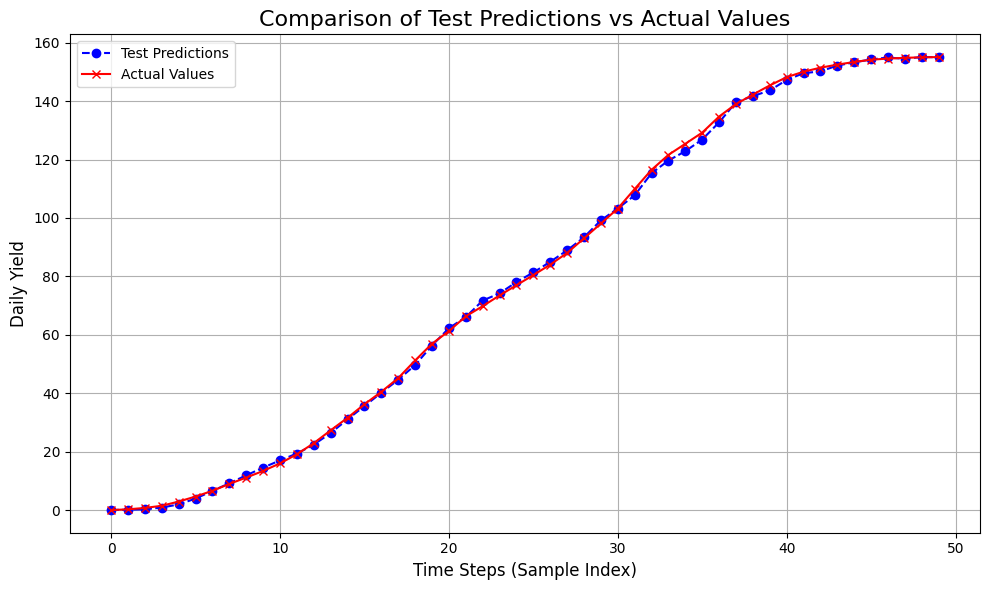

In [67]:
import matplotlib.pyplot as plt

# Set plot size for better visibility
plt.figure(figsize=(10, 6))

# Plot Test Predictions and Actual Values
plt.plot(test_results_2['Test Predictions'][:50], label='Test Predictions', color='blue', linestyle='--', marker='o')
plt.plot(test_results_2['Actual Values'][:50], label='Actual Values', color='red', linestyle='-', marker='x')

# Add labels, title, and grid
plt.title('Comparison of Test Predictions vs Actual Values', fontsize=16)
plt.xlabel('Time Steps (Sample Index)', fontsize=12)
plt.ylabel('Daily Yield', fontsize=12)
plt.grid(True)

# Add a legend to differentiate the lines
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


Mean Squared Error (MSE): 97.4694
Root Mean Squared Error (RMSE): 9.8727
Mean Absolute Error (MAE): 1.6435
R² Score: 0.9738


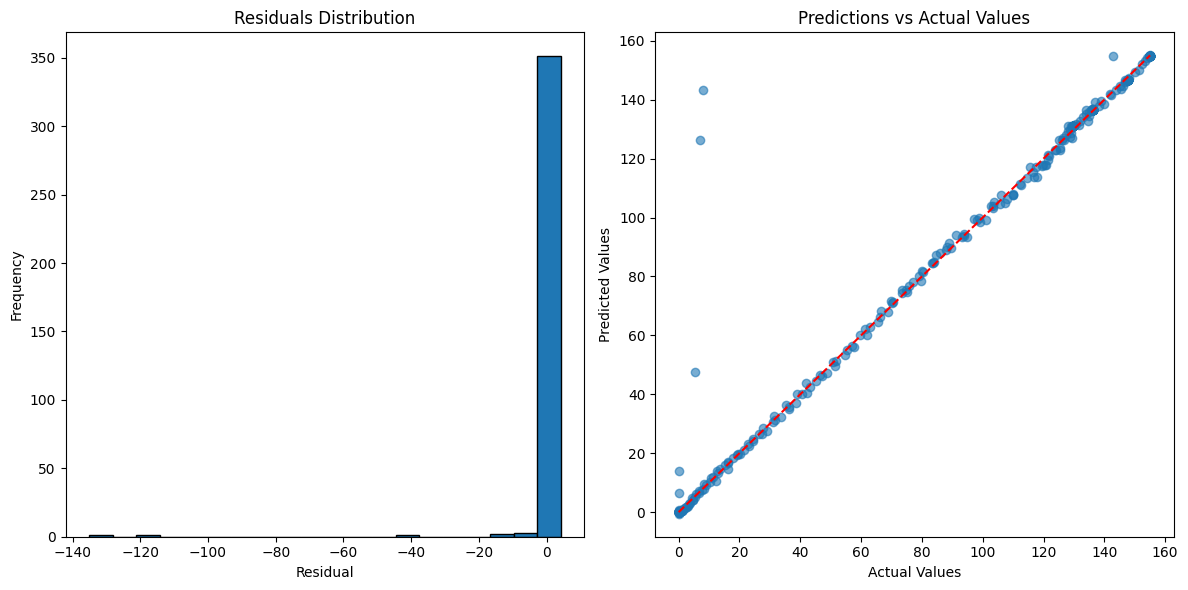

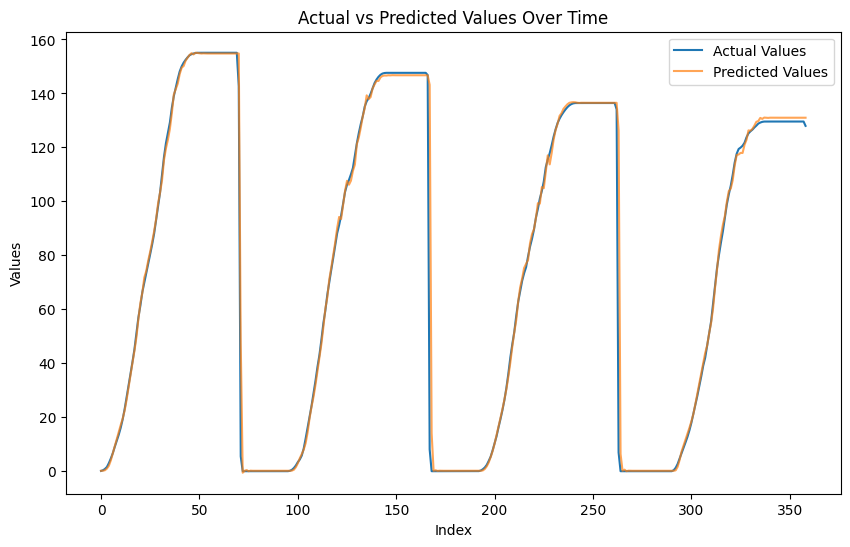

In [68]:
train_metrics_model2 = evaluate_model_performance(y_test, test_predictions_2)